In [11]:
import numpy as np
import pandas as pd
import gzip
import ast
import pyarrow
print(pyarrow.__version__)
print(pd.__version__)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
import re
import scipy.sparse as sp
from xgboost import XGBRegressor

22.0.0
2.3.3


In [ ]:
rows = []
with gzip.open('data/bundle_data.json.gz', 'rt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(ast.literal_eval(line))

bundle_data = pd.DataFrame(rows)
bundle_data.head()

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
0,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':...",10%
1,$20.15,http://store.steampowered.com/bundle/1473/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte...",22%
2,$20.15,http://store.steampowered.com/bundle/1474/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte...",22%
3,$15.17,http://store.steampowered.com/bundle/1437/?utm...,$25.35,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul...",40%
4,$20.15,http://store.steampowered.com/bundle/1466/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte...",22%


In [ ]:
rows = []
with gzip.open('data/australian_users_items.json.gz', 'rt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(ast.literal_eval(line)) 

rev_df = pd.DataFrame(rows)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [3]:
rows = []

with gzip.open('data/steam_reviews.json.gz', 'rt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(ast.literal_eval(line))

df = pd.DataFrame(rows)

df.to_parquet('steam_reviews.parquet', engine='pyarrow', index=False)


In [16]:
df.shape[1]
df.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [5]:
def mark_caps(word):
    # Mark words that are all uppercase and longer than 1 character
    if word.isupper() and len(word) > 1:
        return word.lower() + " <allcaps>"
    return word

def clean_text(text, mark_allcaps=True):
    if not isinstance(text, str):
        return ""

    # Normalize any sequence of ♥ to a token
    text = re.sub(r'[♥]+', ' <censored> ', text)

    # Replace repeated punctuation / emojis with tokens
    text = re.sub(r'!{2,}', ' <exclaim> ', text)   # !!! → <exclaim>
    text = re.sub(r'\?{2,}', ' <question> ', text) # ??? → <question>
    text = re.sub(r':\)', ' <smile> ', text)       # :) → <smile>

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Optionally mark all-caps words
    if mark_allcaps:
        text = ' '.join(mark_caps(w) for w in text.split())

    # Lowercase everything (words that weren't all-caps are fine)
    text = text.lower()

    # Allow letters, digits, common sentiment punctuation, +-/ and the token brackets <>
    text = re.sub(r'[^a-z0-9<>\s!\?\.,:\+\-/]', ' ', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


df['cleaned_text'] = df['text'].apply(clean_text)
df['received_free'] = (df['compensation'] == 'Product received for free').astype(int)
df = df.drop(columns=['compensation'])
df['found_funny'] = df['found_funny'].fillna(0).astype(int)
df['found_funny_log'] = np.log1p(df['found_funny'])
df['hours'] = np.log1p(df['hours'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing values in critical columns (hours, products, date)
df = df.dropna(subset=['hours', 'products', 'date', 'user_id', 'product_id'])
# Extract Date Features
df['review_month'] = df['date'].dt.month
df['review_dow'] = df['date'].dt.dayofweek

user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

df.to_parquet('steam_reviews.parquet', index=False)

In [6]:
df.shape[0]

3158609

In [ ]:
# -------------------------
# 0. Text cleaning
# -------------------------
# def mark_caps(word):
#     if word.isupper() and len(word) > 1:
#         return word.lower() + " <allcaps>"
#     return word

# def clean_text(text, mark_allcaps=True):
#     if not isinstance(text, str):
#         return ""
#     text = re.sub(r'[♥]+', ' <censored> ', text)
#     text = re.sub(r'!{2,}', ' <exclaim> ', text)
#     text = re.sub(r'\?{2,}', ' <question> ', text)
#     text = re.sub(r':\)', ' <smile> ', text)
#     if mark_allcaps:
#         text = ' '.join(mark_caps(w) for w in text.split())
#     text = text.lower()
#     text = re.sub(r'[^a-z0-9<>\s!\?\.,:\+\-/]', ' ', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text

# -------------------------
# 1. Preprocess dataframe
# -------------------------
# df['cleaned_text'] = df['text'].apply(clean_text)
# df['received_free'] = (df['compensation'] == 'Product received for free').astype(int)
# df['found_funny'] = df['found_funny'].fillna(0).astype(int)
# df['hours'] = np.log1p(df['hours'])
# df['date'] = pd.to_datetime(df['date'], errors='coerce')

# df = df.drop(columns=['compensation'])
# df = df.dropna(subset=['hours', 'products', 'date'])
# df['user_id'] = df['user_id'].fillna('unknown_user')
# df['product_id'] = df['product_id'].fillna('unknown_product')

# df['review_month'] = df['date'].dt.month
# df['review_dow'] = df['date'].dt.dayofweek

# user_codes = df['user_id'].astype('category').cat.codes
# item_codes = df['product_id'].astype('category').cat.codes

# -------------------------
# 2. Train/Validation/Test split
# -------------------------
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

y_train = train_df['hours'].values
y_val = val_df['hours'].values
y_test = test_df['hours'].values

# -------------------------
# 3. Text Features: TF-IDF
# -------------------------
tfidf = TfidfVectorizer(max_features=1000, stop_words='english', n_jobs=-1)
X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text = tfidf.transform(val_df['cleaned_text'])
X_test_text = tfidf.transform(test_df['cleaned_text'])

# -------------------------
# 4. Numeric Features
# -------------------------
numeric_features = ['products', 'found_funny', 'review_month', 'review_dow', 'received_free']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features)
])

X_train_meta = preprocessor.fit_transform(train_df)
X_val_meta = preprocessor.transform(val_df)
X_test_meta = preprocessor.transform(test_df)

# -------------------------
# 5. Combine text + meta
# -------------------------
X_train = sp.hstack([X_train_text, X_train_meta])
X_val = sp.hstack([X_val_text, X_val_meta])
X_test = sp.hstack([X_test_text, X_test_meta])

# -------------------------
# 6. Train LinearSVR
# -------------------------
svr = SGDRegressor(
    loss='epsilon_insensitive',  # linear SVR loss
    max_iter=1000,               # can increase if convergence warning appears
    tol=1e-3,                    # stopping tolerance
    alpha=1e-4,                  # regularization strength
    random_state=42,
    n_jobs=-1                     # parallelize across CPU cores
)
svr.fit(X_train, y_train)
y_train_svr = svr.predict(X_train)
y_val_svr = svr.predict(X_val)
y_test_svr = svr.predict(X_test)

# -------------------------
# 7. Collaborative Filtering / MF (optimized)
# -------------------------
train_residuals = y_train - y_train_svr

# categorical encoding
user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

# Slice codes for training set
train_user_idx = train_df['user_id'].astype('category').cat.codes
train_item_idx = train_df['product_id'].astype('category').cat.codes

R = sp.coo_matrix(
    (train_residuals, (train_user_idx, train_item_idx)),
    shape=(len(user_codes), len(item_codes))  # full user-item space
)

# fast MF
svd = TruncatedSVD(
    n_components=30,
    n_iter=2,
    random_state=42
)
user_factors = svd.fit_transform(R)
item_factors = svd.components_.T

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

# Map MF predictions to train/val/test
user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

def mf_predict(df_subset):
    u_idx = df_subset['user_id'].map(user_map).values
    i_idx = df_subset['product_id'].map(item_map).values
    return np.array([user_factors[u] @ item_factors[i] for u, i in zip(u_idx, i_idx)])


train_pred_mf = mf_predict(train_df)
val_pred_mf   = mf_predict(val_df)
test_pred_mf  = mf_predict(test_df)

# -------------------------
# 8. EM / Gaussian Mixture on residuals
# -------------------------
residuals = (y_train - y_train_svr).reshape(-1, 1)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(residuals)

cluster_means = gmm.means_.flatten()

# -------------------------
# 9. Combine SVR + MF + GMM residuals
# -------------------------
def combined_prediction(svr_pred, mf_pred, gmm, cluster_means, alpha=0.5):
    # residual distribution conditioning is based on MF-SVR gap
    residual_guess = (mf_pred - svr_pred).reshape(-1, 1)
    probs = gmm.predict_proba(residual_guess)
    expected_residual = np.dot(probs, cluster_means)
    return alpha * svr_pred + (1 - alpha) * mf_pred + expected_residual

y_val_combined = combined_prediction(y_val_svr, val_pred_mf, gmm, cluster_means)
y_test_combined = combined_prediction(y_test_svr, test_pred_mf, gmm, cluster_means)

# -------------------------
# 10. Evaluation
# -------------------------
def evaluate(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R2: {r2:.4f}")

evaluate(y_val, y_val_combined, "Validation")
evaluate(y_test, y_test_combined, "Test")

print("Pipeline ready.")
print("X_train shape:", X_train.shape)
print("Sparse user-item matrix R:", R.shape)
print("User factors:", user_factors.shape)
print("Item factors:", item_factors.shape)

In [15]:
## XGBoost version

# ===============================================================
# 2. Train/Validation/Test split
# ===============================================================
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

y_train = train_df['hours'].values
y_val   = val_df['hours'].values
y_test  = test_df['hours'].values


# ===============================================================
# 3. TF-IDF (fast)
# ===============================================================
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english'
)

X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text   = tfidf.transform(val_df['cleaned_text'])
X_test_text  = tfidf.transform(test_df['cleaned_text'])


# ===============================================================
# 4. Numeric metadata features
# ===============================================================
numeric = ['products','found_funny','review_month','review_dow','received_free']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric)
])

X_train_meta = preprocessor.fit_transform(train_df)
X_val_meta   = preprocessor.transform(val_df)
X_test_meta  = preprocessor.transform(test_df)


# ===============================================================
# 5. Combine text + meta features
# ===============================================================
X_train = sp.hstack([X_train_text, X_train_meta])
X_val   = sp.hstack([X_val_text,   X_val_meta])
X_test  = sp.hstack([X_test_text,  X_test_meta])


# ===============================================================
# 6. XGBoost Model (optimized for speed + accuracy)
# ===============================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    tree_method='hist',
    n_jobs=-1,
    verbosity=1
)

xgb.fit(X_train, y_train)

train_pred_xgb = xgb.predict(X_train)
val_pred_xgb   = xgb.predict(X_val)
test_pred_xgb  = xgb.predict(X_test)


# ===============================================================
# 7. Matrix Factorization (MF) on residuals
# ===============================================================

# residuals for MF to learn
train_residuals = y_train - train_pred_xgb

# categorical encoding
user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

# Slice codes for training set
train_user_idx = train_df['user_id'].astype('category').cat.codes
train_item_idx = train_df['product_id'].astype('category').cat.codes

R = sp.coo_matrix(
    (train_residuals, (train_user_idx, train_item_idx)),
    shape=(len(user_codes), len(item_codes))  # full user-item space
)

# fast MF
svd = TruncatedSVD(
    n_components=30,
    n_iter=2,
    random_state=42
)
user_factors = svd.fit_transform(R)
item_factors = svd.components_.T

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

def mf_predict(df_subset):
    u_idx = df_subset['user_id'].map(user_map).values
    i_idx = df_subset['product_id'].map(item_map).values
    return np.array([user_factors[u] @ item_factors[i] for u, i in zip(u_idx, i_idx)])


train_pred_mf = mf_predict(train_df)
val_pred_mf   = mf_predict(val_df)
test_pred_mf  = mf_predict(test_df)


# ===============================================================
# 8. Combined Prediction (Hybrid)
# ===============================================================
train_pred = train_pred_xgb + train_pred_mf
val_pred   = val_pred_xgb   + val_pred_mf
test_pred  = test_pred_xgb  + test_pred_mf


# ===============================================================
# 9. Evaluation
# ===============================================================
def evaluate(y, yhat, name):
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2   = r2_score(y, yhat)
    print(f"{name}: RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_val, val_pred, "Validation")
evaluate(y_test, test_pred, "Test")

print("Pipeline complete.")

Validation: RMSE=1.6083, R2=0.1870
Test: RMSE=1.6083, R2=0.1870
Pipeline complete.


                  Model  Train MSE  Train MAE    Val MSE   Val MAE   Test MSE  \
0               XGBoost   2.522434   1.273705   2.586722  1.290171   2.586362   
1  Matrix Factorization  12.890573   3.114857  12.886195  3.115175  12.864741   
2                Hybrid   2.522770   1.273743   2.586772  1.290180   2.586716   

   Test MAE  
0  1.289971  
1  3.111736  
2  1.289996  


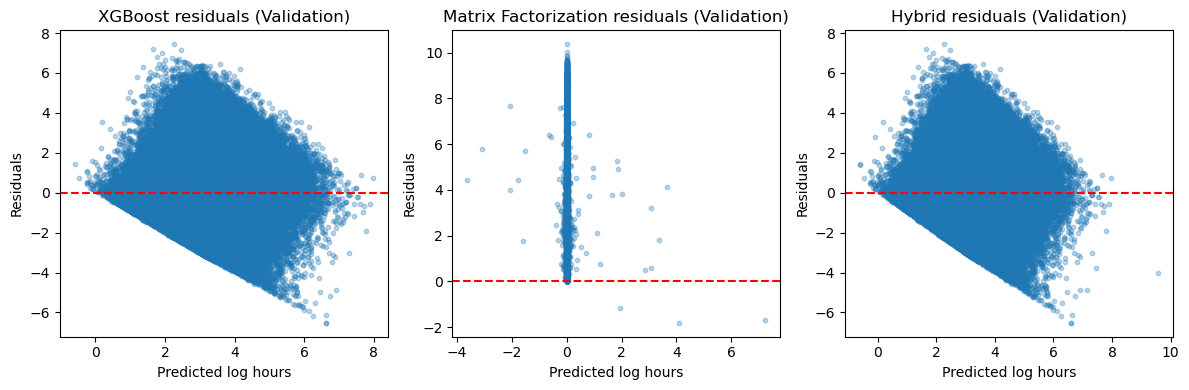

In [16]:
# ===========================
# 1. Define evaluation function
# ===========================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

# ===========================
# 2. Compute metrics for all models
# ===========================
models = {
    "XGBoost": (train_pred_xgb, val_pred_xgb, test_pred_xgb),
    "Matrix Factorization": (train_pred_mf, val_pred_mf, test_pred_mf),
    "Hybrid": (train_pred, val_pred, test_pred)
}

metrics_dict = {}

for name, (train_pred, val_pred, test_pred) in models.items():
    metrics_dict[name] = {
        "Train MSE, MAE": compute_metrics(y_train, train_pred),
        "Val MSE, MAE": compute_metrics(y_val, val_pred),
        "Test MSE, MAE": compute_metrics(y_test, test_pred)
    }

# Convert metrics to a DataFrame for display
rows = []
for model_name, scores in metrics_dict.items():
    rows.append({
        "Model": model_name,
        "Train MSE": scores["Train MSE, MAE"][0],
        "Train MAE": scores["Train MSE, MAE"][1],
        "Val MSE": scores["Val MSE, MAE"][0],
        "Val MAE": scores["Val MSE, MAE"][1],
        "Test MSE": scores["Test MSE, MAE"][0],
        "Test MAE": scores["Test MSE, MAE"][1],
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

# ===========================
# 3. Plot predicted log hours vs residuals for all models (Validation set)
# ===========================
plt.figure(figsize=(12,4))

for i, (name, (_, val_pred, _)) in enumerate(models.items(), 1):
    residuals = y_val - val_pred
    plt.subplot(1, 3, i)
    plt.scatter(val_pred, residuals, alpha=0.3, s=10)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted log hours")
    plt.ylabel("Residuals")
    plt.title(f"{name} residuals (Validation)")

plt.tight_layout()
plt.show()